# 0.Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

# 1. Clustering por producto

In [2]:
df = pd.read_csv(r"C:\Users\alici\Documents\master_data_science\proyecto_nuclio\TFM\datos_arreglados.csv", index_col=0)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

df.head()

,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
date,,,,,,,,,,,
2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0,12.7414,0.0000
2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0,12.7414,0.0000
2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4,10.9858,43.9432
2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6,10.9858,65.9148
2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0,10.9858,0.0000


Para realizar un clustering de productos similares, debemos centrarnos en las variables que describen mejor las características y el comportamiento de los productos. En este caso, las variables que podrían ser más útiles para un análisis de clustering son:

*-item:* Identificador del producto, que nos permitirá diferenciar cada uno de ellos.

*-category:* La categoría del producto es una característica fundamental que agrupa productos similares.

*-department:* Similar a la categoría, pero puede ser una clasificación más amplia dentro de la tienda.

*-units_sold:* La cantidad de unidades vendidas puede indicar la popularidad o la demanda del producto.

*-sell_price:* El precio de venta nos da una idea del segmento de mercado del producto (económico, premium, etc.).

*-total_sales:* Representa el ingreso total generado por el producto, que puede ser un reflejo de su éxito y su posición en el mercado.

Las variables como *date, week, year* y *is_holidays* son temporales y contextuales, y no necesariamente reflejan las propiedades intrínsecas de los productos. Sin embargo, podríamos incluir más adelante *is_holidays* puesto que la venta de ciertos productos puede estar fuertemente influenciada por temporadas festivas, lo que podría ayudar a identificar productos de temporada.

### 1.1. Baseline

Vamos a intentar obtener un rendimiento histórico por producto para poder añadirlo al clustering.

In [3]:
aggregated_data = df.copy()

In [4]:
# Agregamos datos para cada producto
aggregated_data = df.groupby('item').agg({
    'units_sold': ['mean', 'sum', 'std'],
    'sell_price': 'mean',
    'total_sales': 'mean',
    'is_holidays': 'sum'
}).reset_index()

# Aplanamos las columnas multindex para simplificar el índice en una sola capa
aggregated_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in aggregated_data.columns.values]

# Renombramos las columnas para que tengan nombres más claros
# Cada fila corresponderá a un producto único y las columnas representarán las estadísticas agregadas de ese producto a lo largo del tiempo
aggregated_data.rename(columns={
    'units_sold_mean': 'avg_units_sold', # Promedio de unidades vendidas por producto
    'units_sold_sum': 'total_units_sold', # Total de unidades vendidas por producto
    'units_sold_std': 'std_units_sold', # Desviación de los datos. Un valor alto( gran dispersión), uno bajo(los datos son más consistentes). Podríamos compararlo con otros productos y con respecto a la media
    'sell_price_mean': 'avg_sell_price', # Precio de venta promedio del producto
    'total_sales_mean': 'avg_total_sales', # Promedio de ventas totales
    'is_holidays_sum': 'total_holiday_weeks' # Suma del número de veces que las ventas del producto ocurrieron durante una semana de vacaciones
}, inplace=True)

aggregated_data.round(2)

,item,avg_units_sold,total_units_sold,std_units_sold,avg_sell_price,avg_total_sales,total_holiday_weeks
0,ACCESORIES_1_001,2.78,4051,2.40,11.04,30.57,374
1,ACCESORIES_1_002,1.91,5047,2.23,5.28,10.10,656
2,ACCESORIES_1_003,1.25,1405,1.63,3.94,4.93,284
3,ACCESORIES_1_004,14.35,38996,13.13,5.98,86.17,679
4,ACCESORIES_1_005,5.63,14529,5.20,3.83,21.44,657
...,...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,5.84,15290,9.87,3.34,19.29,661
3045,SUPERMARKET_3_824,3.03,8315,3.58,3.03,9.26,690
3046,SUPERMARKET_3_825,4.92,13465,5.55,4.93,23.94,686
3047,SUPERMARKET_3_826,7.67,12121,5.79,1.54,11.78,398


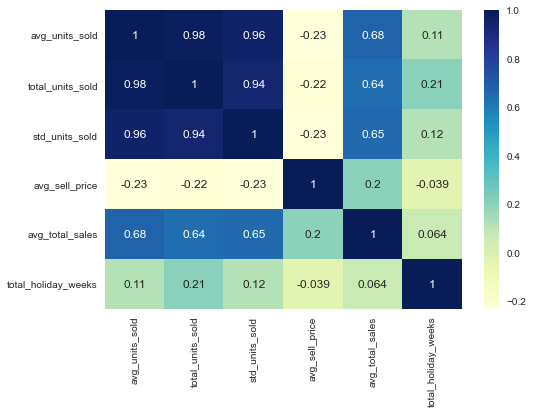

In [5]:
# Obtenemos la correlación de las diferentes variables
sns.heatmap(aggregated_data.corr(), annot=True, cmap="YlGnBu");

Procederemos a eliminar las variables que tengan una alta correlación entre sí para no añadirlas al modelo.

In [6]:
df_cluster_product = aggregated_data.copy()

In [7]:
df_cluster_product.drop(columns=['total_units_sold','std_units_sold','avg_total_sales','total_holiday_weeks'], inplace=True)
productos = df_cluster_product.pop('item')
productos

0        ACCESORIES_1_001
1        ACCESORIES_1_002
2        ACCESORIES_1_003
3        ACCESORIES_1_004
4        ACCESORIES_1_005
              ...        
3044    SUPERMARKET_3_823
3045    SUPERMARKET_3_824
3046    SUPERMARKET_3_825
3047    SUPERMARKET_3_826
3048    SUPERMARKET_3_827
Name: item, Length: 3049, dtype: object

In [8]:
# Estandarizamos las características
ss = StandardScaler()
df_cluster_product_ss = pd.DataFrame(
    ss.fit_transform(df_cluster_product),
    columns= df_cluster_product.columns)
df_cluster_product_ss

,avg_units_sold,avg_sell_price
0,-0.386216,1.206081
1,-0.437267,-0.063860
2,-0.476255,-0.357528
3,0.295774,0.091511
4,-0.218034,-0.381801
...,...,...
3044,-0.205980,-0.489608
3045,-0.371113,-0.559770
3046,-0.259994,-0.139359
3047,-0.098054,-0.888269


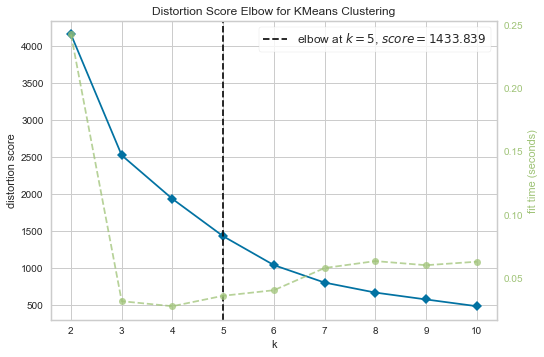

In [9]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_product_ss)
Elbow_M.show();

In [10]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_product_ss)
    silhouette_scores.append(silhouette_score(df_cluster_product_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

In [11]:
kmeans= KMeans(n_clusters=3,random_state=42, init="random", n_init="auto")
kmeans.fit(df_cluster_product_ss)
aggregated_data["cluster"] = kmeans.labels_

c:\Users\alici\anaconda3\envs\Nuclio_env\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



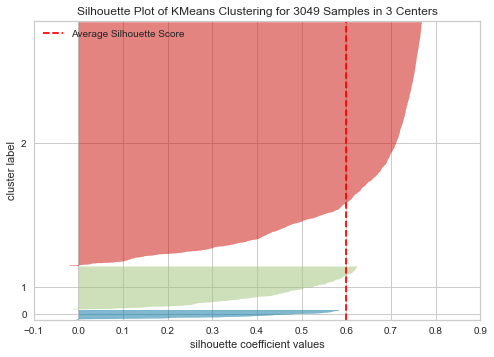

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3049 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(df_cluster_product_ss)  
visualizer.show()

In [13]:
aggregated_data.head()

,item,avg_units_sold,total_units_sold,std_units_sold,avg_sell_price,avg_total_sales,total_holiday_weeks,cluster
0,ACCESORIES_1_001,2.778464,4051,2.401590,11.039091,30.565078,374,1
1,ACCESORIES_1_002,1.912467,5047,2.228322,5.276618,10.096519,656,2
2,ACCESORIES_1_003,1.251113,1405,1.631133,3.944072,4.927632,284,2
3,ACCESORIES_1_004,14.347314,38996,13.127277,5.981629,86.174086,679,2
4,ACCESORIES_1_005,5.631395,14529,5.202769,3.833931,21.441100,657,2


### 1.2. Preprocesamiento 2

En esta segunda iteración, vamos a analizar el clustering de productos por temporadas (cuatrimestres).

In [14]:
# Creamos una columna 'quarter' a partir del índice 'date'
df['quarter'] = df.index.month // 4 + 1  

# Calculamos los porcentajes de ventas por ítem y región para cada cuatrimestre
df_perc_quarter_item = pd.crosstab(df['item'], df['quarter'], values=df['total_sales'], aggfunc='sum', normalize='index').reset_index()

# El resultado df_perc es un DataFrame con los porcentajes normalizados por tienda y cuatrimestre
df_perc_quarter_item

quarter,item,1,2,3,4
0,ACCESORIES_1_001,0.281263,0.269487,0.351586,0.097664
1,ACCESORIES_1_002,0.199654,0.276641,0.344166,0.179539
2,ACCESORIES_1_003,0.289062,0.323099,0.258637,0.129202
3,ACCESORIES_1_004,0.266751,0.332820,0.313277,0.087152
4,ACCESORIES_1_005,0.234197,0.285362,0.376911,0.103530
...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.286232,0.264262,0.358336,0.091170
3045,SUPERMARKET_3_824,0.220570,0.422692,0.304179,0.052560
3046,SUPERMARKET_3_825,0.301703,0.335997,0.290497,0.071804
3047,SUPERMARKET_3_826,0.242761,0.385055,0.301477,0.070708


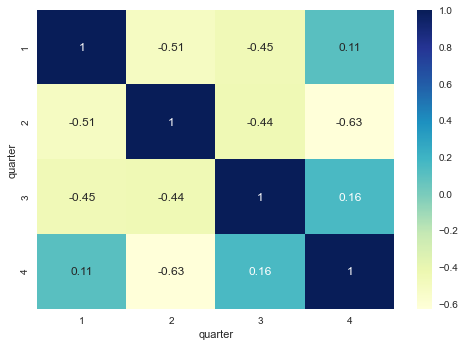

In [15]:
# Obtenemos la correlación de las diferentes variables
sns.heatmap(df_perc_quarter_item.corr(), annot=True, cmap="YlGnBu");

In [16]:
df_cluster_quarter = df_perc_quarter_item.copy()

In [17]:
productos_quarter = df_cluster_quarter.pop('item')
productos_quarter

0        ACCESORIES_1_001
1        ACCESORIES_1_002
2        ACCESORIES_1_003
3        ACCESORIES_1_004
4        ACCESORIES_1_005
              ...        
3044    SUPERMARKET_3_823
3045    SUPERMARKET_3_824
3046    SUPERMARKET_3_825
3047    SUPERMARKET_3_826
3048    SUPERMARKET_3_827
Name: item, Length: 3049, dtype: object

In [18]:
# Estandarizamos las características
ss = StandardScaler()
df_cluster_quarter_ss = pd.DataFrame(
    ss.fit_transform(df_cluster_quarter),
    columns= df_cluster_quarter.columns)
df_cluster_quarter_ss

quarter,1,2,3,4
0,0.294480,-0.998906,0.649205,0.670123
1,-1.474984,-0.875332,0.475104,3.978920
2,0.463571,-0.072881,-1.531710,1.944648
3,-0.020167,0.095021,-0.249666,0.245283
4,-0.726012,-0.724695,1.243415,0.907168
...,...,...,...,...
3044,0.402209,-1.089143,0.807590,0.407662
3045,-1.021481,1.647326,-0.463141,-1.152677
3046,0.737654,0.149883,-0.784165,-0.374962
3047,-0.540336,0.997243,-0.526538,-0.419265


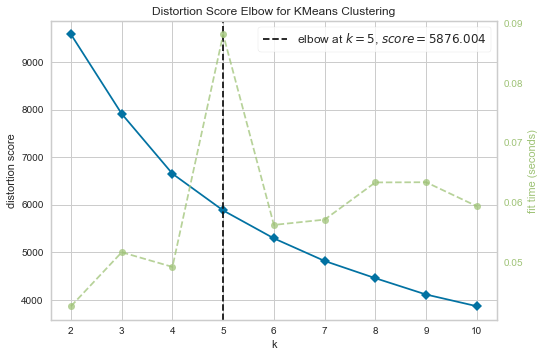

In [19]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_quarter_ss)
Elbow_M.show();

In [20]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_product_ss)
    silhouette_scores.append(silhouette_score(df_cluster_quarter_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

In [21]:
kmeans= KMeans(n_clusters=2,random_state=42, init="random", n_init="auto")
kmeans.fit(df_cluster_quarter_ss)
df_perc_quarter_item["cluster"] = kmeans.labels_

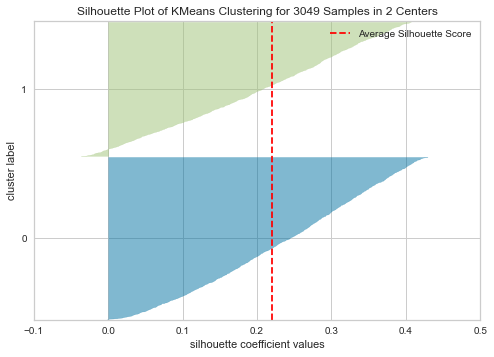

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3049 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(df_cluster_quarter_ss)  
visualizer.show()

In [23]:
df_perc_quarter_item.head()

quarter,item,1,2,3,4,cluster
0,ACCESORIES_1_001,0.281263,0.269487,0.351586,0.097664,1
1,ACCESORIES_1_002,0.199654,0.276641,0.344166,0.179539,1
2,ACCESORIES_1_003,0.289062,0.323099,0.258637,0.129202,1
3,ACCESORIES_1_004,0.266751,0.332820,0.313277,0.087152,0
4,ACCESORIES_1_005,0.234197,0.285362,0.376911,0.103530,1


### 1.3. Preprocesamiento 3

En una tercera iteración, añadiremos a la segunda la variable *region*.

In [24]:
# Creamos una columna 'quarter' a partir del índice 'date'
df['quarter'] = df.index.month // 4 + 1  

# Calculamos los porcentajes de ventas por ítem y ciudad para cada trimestre
df_perc_quarter_region = pd.crosstab([df['item'], df['region']], df['quarter'], values=df['total_sales'], aggfunc='sum', normalize='index').reset_index()

# El resultado df_perc es un DataFrame con los porcentajes normalizados por ítem, ciudad y trimestre
df_perc_quarter_region


quarter,item,region,1,2,3,4
0,ACCESORIES_1_001,Boston,0.258490,0.288823,0.353621,0.099066
1,ACCESORIES_1_001,New York,0.290651,0.256298,0.351402,0.101649
2,ACCESORIES_1_001,Philadelphia,0.280930,0.295676,0.348362,0.075032
3,ACCESORIES_1_002,Boston,0.202792,0.323555,0.335800,0.137853
4,ACCESORIES_1_002,New York,0.169339,0.285893,0.349983,0.194784
...,...,...,...,...,...,...
9142,SUPERMARKET_3_826,New York,0.247476,0.389355,0.302071,0.061099
9143,SUPERMARKET_3_826,Philadelphia,0.211521,0.380677,0.328254,0.079549
9144,SUPERMARKET_3_827,Boston,0.286872,0.349271,0.275527,0.088331
9145,SUPERMARKET_3_827,New York,0.351685,0.249020,0.325235,0.074060


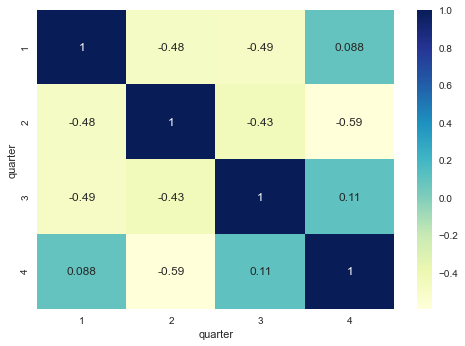

In [25]:
# Obtenemos la correlación de las diferentes variables
sns.heatmap(df_perc_quarter_region.corr(), annot=True, cmap="YlGnBu");

In [26]:
df_cluster_quarter_region = df_perc_quarter_region.copy()

In [27]:
df_cluster_quarter_region.drop(columns=['region'], inplace=True)
productos_quarter_region = df_cluster_quarter_region.pop('item')
productos_quarter_region

0        ACCESORIES_1_001
1        ACCESORIES_1_001
2        ACCESORIES_1_001
3        ACCESORIES_1_002
4        ACCESORIES_1_002
              ...        
9142    SUPERMARKET_3_826
9143    SUPERMARKET_3_826
9144    SUPERMARKET_3_827
9145    SUPERMARKET_3_827
9146    SUPERMARKET_3_827
Name: item, Length: 9147, dtype: object

In [28]:
# Estandarizamos las características
ss = StandardScaler()
df_cluster_quarter_region_ss = pd.DataFrame(
    ss.fit_transform(df_cluster_quarter_region),
    columns= df_cluster_quarter_region.columns)
df_cluster_quarter_region_ss

quarter,1,2,3,4
0,-0.206141,-0.597651,0.617008,0.648634
1,0.403901,-1.109953,0.572758,0.742410
2,0.219498,-0.489709,0.512148,-0.223905
3,-1.262656,-0.050571,0.261673,2.056823
4,-1.897198,-0.643794,0.544471,4.123754
...,...,...,...,...
9142,-0.415073,0.985851,-0.410858,-0.729771
9143,-1.097077,0.849160,0.111199,-0.059928
9144,0.332213,0.354478,-0.940121,0.258896
9145,1.561612,-1.224584,0.051014,-0.259222


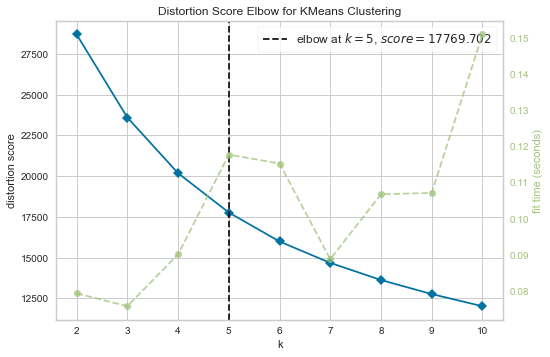

In [29]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_quarter_region_ss)
Elbow_M.show();

In [30]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_quarter_region_ss)
    silhouette_scores.append(silhouette_score(df_cluster_quarter_region_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

In [31]:
kmeans= KMeans(n_clusters=4,random_state=42, init="random", n_init="auto")
kmeans.fit(df_cluster_quarter_region_ss)
df_perc_quarter_region["cluster"] = kmeans.labels_

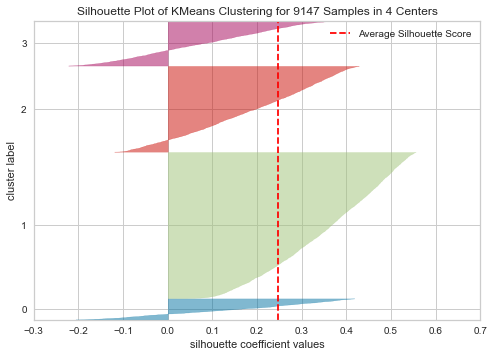

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 9147 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(df_cluster_quarter_region_ss)  
visualizer.show()

In [33]:
df_perc_quarter_region.head()

quarter,item,region,1,2,3,4,cluster
0,ACCESORIES_1_001,Boston,0.258490,0.288823,0.353621,0.099066,3
1,ACCESORIES_1_001,New York,0.290651,0.256298,0.351402,0.101649,3
2,ACCESORIES_1_001,Philadelphia,0.280930,0.295676,0.348362,0.075032,1
3,ACCESORIES_1_002,Boston,0.202792,0.323555,0.335800,0.137853,3
4,ACCESORIES_1_002,New York,0.169339,0.285893,0.349983,0.194784,3
